In [82]:
import copy
import numpy as np
import pandas as pd
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
#datacleaning()

# 读取数据
ori_a=np.loadtxt('train_input.csv',dtype=np.float64)
b=np.loadtxt('output.txt',dtype=np.float64)

def tran_learn(data, label):
    # 1 3 5 6 7
    new_data = []
    for i in range(len(data)):
        if i < 3:
            continue
        new_data_piece = []
        for j in range(5):
            new_data_piece.append(data[i][j])
        for j in range(3):
            new_data_piece.append(data[i - j - 1][4])
            new_data_piece.append(data[i - j - 1][2])
            new_data_piece.append(data[i - j - 1][0])
        new_data_piece.append((data[i][5] + data[i][6])/2)
        new_data.append(np.array(new_data_piece))
    return np.array(new_data), label[3:]



print("x_train.shape ->", ori_a.shape)
print("y_train.shape ->", b.shape)

mode = 1
if mode == 1:
    b = b[:,np.newaxis]
    a, b = tran_learn(ori_a, b)
if mode == 2:
    b = b[:,np.newaxis]
    a[5] =(a[6]+a[5])/2
    a = np.delete(a,6,axis=1)

print("x_train.shape ->", a.shape)
print("y_train.shape ->", b.shape)



x_train.shape -> (1596, 7)
y_train.shape -> (1596,)
x_train.shape -> (1593, 15)
y_train.shape -> (1593, 1)


In [83]:
#按行拼接，训练集输出也是信息
values=np.concatenate((a,b),axis=1)
#深复制而非浅复制，很有意思的
data = copy.deepcopy(values)
data = pd.DataFrame(data)
def series_to_supervised(data, n_in, n_out):
    df = pd.DataFrame(data)
    n_vars = df.shape[1]  # n_vars 列数
    cols, names = list(), list()

    # 时间间隔跨度, 时间点个数，共 n_in 个
    # 首先添加当前时刻之前的时间点
    for i in range(n_in - 1, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 然后添加当前时刻
    cols.append(df)
    names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]

    # 添加 target 为未来 n_out 分钟后时刻的温度
    cols.append(df.shift(-n_out))
    names += [('var%d(t+%d)' % (j + 1, n_out)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除缺失值
    agg.dropna(inplace=True)
    return agg
# 确保所有数据是 float64 类型
data = data.astype('float64')
print(data.shape)
# data
data.head()

(1593, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.267451,0.668338,0.808371,0.565689,0.752605,0.764546,0.823618,0.267967,0.776487,0.852153,0.268483,0.784759,0.832742,0.268900,0.792926,0.171640
1,0.266935,0.647191,0.761948,0.559779,0.745326,0.752605,0.808371,0.267451,0.764546,0.823618,0.267967,0.776487,0.852153,0.268483,0.759632,0.166972
2,0.266419,0.633665,0.774621,0.555084,0.756059,0.745326,0.761948,0.266935,0.752605,0.808371,0.267451,0.764546,0.823618,0.267967,0.798857,0.163679
3,0.265904,0.654012,0.774420,0.551762,0.766794,0.756059,0.774621,0.266419,0.745326,0.761948,0.266935,0.752605,0.808371,0.267451,0.836228,0.160249
4,0.265388,0.672287,0.773997,0.548440,0.761244,0.766794,0.774420,0.265904,0.756059,0.774621,0.266419,0.745326,0.761948,0.266935,0.813842,0.158242


In [84]:
# 构建成监督学习数据集
# 比如根据当前时刻及之前100时刻的数据预测下一个时刻
# 这实际上是在获取 t - n_in + 1 时刻到 t 时刻共 n_in 个特征和第 t + n_out 时刻目标值
number1=50
number2=1

In [92]:
reframed = series_to_supervised(data, number1, number2)
reframed.head()
print(reframed.shape)
# reframed

(1543, 816)


In [93]:
#丢弃我们不想预测的列,这里预测的是最后一列，丢弃其他列
if mode == 2:
    drop_col = [number1*7, number1*7+1, number1*7+2, number1*7+3, number1*7+4, number1*7+5]
    reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
    reframed.head()
if mode == 1:
    drop_col = [number1*16,   number1*16+1, number1*16+2, 
                number1*16+3, number1*16+4, number1*16+5, 
                number1*16+6, number1*16+7, number1*16+8,
                number1*16+9, number1*16+10,number1*16+11,
                number1*16+12,number1*16+13,number1*16+14,]
    reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
    reframed.head()

In [94]:
# 把数据分为训练集和测试集
values = reframed.values
print(values.shape)

(1543, 801)


In [95]:
test = values[:int(values.shape[0]*0.2), :]
train = values[int(values.shape[0]*0.2):, :]

# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print("训练集数据 shape:", train_X.shape)
print("训练集标签 shape:", train_y.shape)
print("测试集数据 shape:", test_X.shape)
print("测试集标签 shape:", test_y.shape)


训练集数据 shape: (1235, 800)
训练集标签 shape: (1235,)
测试集数据 shape: (308, 800)
测试集标签 shape: (308,)


In [96]:
# 把输入重塑成符合LSTM输入的3D格式 [样例， 时间步, 特征]

if mode == 1:
    train_X = train_X.reshape((train_X.shape[0], number1, 16))
    test_X = test_X.reshape((test_X.shape[0], number1, 16))
if mode == 2:
    train_X = train_X.reshape((train_X.shape[0], number1, 7))
    test_X = test_X.reshape((test_X.shape[0], number1, 7))

print("训练集数据 shape:", train_X.shape)
print("训练集标签 shape:", train_y.shape)
print("测试集数据 shape:", test_X.shape)
print("测试集标签 shape:", test_y.shape)

训练集数据 shape: (1235, 50, 16)
训练集标签 shape: (1235,)
测试集数据 shape: (308, 50, 16)
测试集标签 shape: (308,)


In [128]:
epochs=100
batch_size = 32
learning_rate = 0.001
patience=3

In [137]:
import math
from keras.losses import mean_squared_error
from keras.callbacks import ReduceLROnPlateau
from keras.optimizer_v2.adam import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.layers import Dropout, LSTM, Activation

# 搭建lstm网络模型，activation="RELU"
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.1))
# model.add(SimpleRNN(units=64, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(32))
# 原本是model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])
model.summary()


lrate = ReduceLROnPlateau(monitor= 'val_loss',min_lr=0.00001,patience=patience,factor=0.5)
# 拟合网络，batch_size默认32
history = model.fit(train_X,
                    train_y,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data=(test_X, test_y),
                    callbacks=lrate,
                    verbose=1,
                    shuffle=True)
# 保存模型
model_path = 'results/LSTM.h5'
model.save(model_path)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 50, 64)            20736     
_________________________________________________________________
activation_15 (Activation)   (None, 50, 64)            0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 50, 64)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_33 (Dense)             (None, 32)              

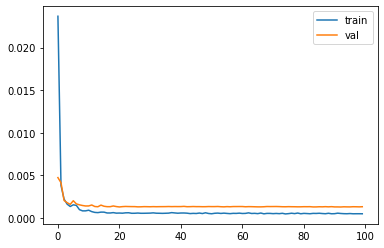

[0.0013178426306694746, 0.0]


In [138]:
# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
# 模型评估
score = model.evaluate(test_X, test_y, verbose=0)
print(score)
# 观察结果

(308,)
(308, 1)
(308,)


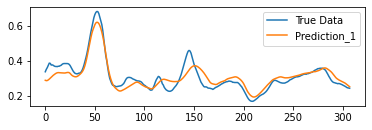

In [139]:
from tensorflow.keras.models import load_model
# 加载模型调入测试集尝试一下
model = load_model(model_path)

predicted_data = model.predict(test_X)
print(test_y.shape)
print(predicted_data.shape)
print(predicted_data[:,0].shape)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(211)
ax.plot(test_y, label='True Data')
ax.plot(predicted_data[:,0], label='Prediction_1')
ax.legend()
plt.show()

In [140]:
pre_1_dim = predicted_data[:,0]
rmse = math.sqrt(mean_squared_error(test_y,pre_1_dim))
print("模型的RMSE:{}".format(round(rmse,3)))

模型的RMSE:0.036


In [141]:
def tran_validation(train, test):
    new_test = []
    for i in range(3):
        new_test.append(train[-1 - i])
    for i in range(len(test)):
        new_test.append(test[i])
    labels = [_ for _ in range(len(new_test))]  # hahaha
    new_test, labels = tran_learn(np.array(new_test), labels)
    return new_test
a=np.loadtxt('train_input.csv',dtype=np.float64)
# a[5] =(a[6]+a[5])/2
# a = np.delete(a,6,axis=1)
b=np.loadtxt('output.txt',dtype=np.float64)
# b = b[:,np.newaxis]

mode = 1
if mode == 1:
    b = b[:,np.newaxis]
    a, b = tran_learn(a, b)
if mode == 2:
    b = b[:,np.newaxis]
    a[5] =(a[6]+a[5])/2
    a = np.delete(a,6,axis=1)
print(a.shape)
print(b.shape)

c=np.loadtxt('test_input.csv',dtype=np.float64)
if mode == 1:
    c = tran_validation(ori_a, c)
    print(c.shape)
    # c = np.delete(c,9,axis=1)
if mode == 2:
    c[5] = (c[5]+c[6])/2
    c = np.delete(c,6,axis=1)
d=np.ones([798,1], dtype = np.float64)

values=np.concatenate((a,b),axis=1)
values2=np.concatenate((c,d),axis=1)
values = values[-number1:,:]
print(values.shape)
print(values2.shape)

(1593, 15)
(1593, 1)
(798, 15)
(50, 16)
(798, 16)


In [142]:
# 读取数据输出结果
def predict(sequence):
    # 数据处理
    sequence = sequence.astype('float64')
    sequence = np.expand_dims(sequence, 0).repeat(1, axis=0)
    # print(sequence.shape)
    pre_t = model.predict(sequence)
    pre_t = np.float64(pre_t)
    return pre_t

for i in range(798):
    # print(predict(values))
    pre=predict(values)
    d[i] = pre
    # print(d[i])
    values = np.delete(values, 0, axis = 0)
    values2[i,15]=d[i]
    e = values2[i]
    e = e[np.newaxis,:]
    #print(e.shape)
    values=np.concatenate((values,e),axis=0)
    #print(values.shape)
data = pd.DataFrame(values2)
writer = pd.ExcelWriter('results/TESTLSTM.xlsx')
data.to_excel(writer, 'page_1', float_format='%.32f')		# ‘page_1’是写入excel的sheet名
writer.save()
writer.close()